# Описание проекта
В этом проекте мы рассмотрим зарплаты учителей по регионам и составим модель, которая будет предсказывать их зарплату

Данные будут браться с сайта https://trudvsem.ru/

Воспользуемся их api https://trudvsem.ru/opendata/api.

In [1]:
import requests
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt


In [2]:

def get_vacancies(region_code=None, industry=None, source=None, accommodation=None, social_protected=None, experience_from=None, experience_to=None, offset=0, limit=100, modified_from=None, modified_to=None, text=None):
    # отправляет запрос на API trudvsem. В случае ошибки пишет её и возращает None
    if limit > 100:
        print("limit > 100 не поддерживается API, вместо этого limit 100 будет использован.")
    
    if region_code:
        url = f"http://opendata.trudvsem.ru/api/v1/vacancies/region/{region_code}"
    else:
        url = f"http://opendata.trudvsem.ru/api/v1/vacancies"
    
    params = {
        'offset': offset,
        'limit': limit
    }

    if industry:
        params['industry'] = industry
    if source:
        params['source'] = source
    if accommodation:
        params['accommodation'] = accommodation
    if social_protected:
        params['social_protected'] = social_protected
    if experience_from:
        params['experienceFrom'] = experience_from
    if experience_to:
        params['experienceTo'] = experience_to
    if modified_from:
        params['modifiedFrom'] = modified_from
    if modified_to:
        params['modifiedTo'] = modified_to
    if text:
        params['text'] = text

    response = requests.get(url, params=params)

    if response.status_code == 200:
        vacancies = response.json()
        return vacancies
    else:
        print("Ошибка при отправке запроса:", response.status_code)
        return None


Документация API неполная и непонятно, что значат некоторые параметры параметры. Опытным путем было выяснено, что region_code это цифровое представланение региона. Например Иркутская область это 38. 

In [3]:
a = get_vacancies(text="программист", region_code=38)
print(a['meta']) # посмотрим сколько программистов в области

{'total': 74, 'limit': 100}


In [4]:
def parse_vacancies(vacancies_obj):
    """Переводит результат запроса в DataFrame


    Returns:
        pd.DataFrame
    """
    data = []
    for v in vacancies_obj:
        v = v["vacancy"]
        data.append(
            [
                v.get("source"),
                v.get("region", {}).get("region_code"),
                v.get("regio    data=[]n", {}).get("name"),
                v.get("salary_min"),
                v.get("salary_max"),
                v.get("job-name"),
                v.get("duty"),
                v.get("category", {}).get("specialisation"),
            ]
        )
    return pd.DataFrame(
        data,
        columns=[
            "source",
            "region_code",
            "region_name",
            "salary_min",
            "salary_max",
            "job_name",
            "duty",
            "specialisation",
        ],
    )

def get_api_data(**get_vacancies_args):
    """Обертка для получения запросов, чтобы получить сразу в формате DataFrame и ловить случаи когда банят

    Returns:
        _type_: _description_
    """
    a = get_vacancies(**get_vacancies_args)
    if 'error' in a['meta'] or 'vacancies' not in a['results']:
        print(a)
        return None

    data = a['results']['vacancies']
    return parse_vacancies(data)


teachers_api = get_api_data(text='Учитель')
teachers_api

,source,region_code,region_name,salary_min,salary_max,job_name,duty,specialisation
0,Работодатель,5200000000000,None,25000,0,Учитель,Обеспечение должного уровня подготовки ученико...,"Образование, наука"
1,Работодатель,7100000000000,None,20000,0,учитель,<p>в соответствии с должностными обязанностями...,"Образование, наука"
2,Работодатель,3600000000000,None,25000,0,учитель математики,<p>учитель</p>,"Образование, наука"
3,Работодатель,1200000000000,None,16242,0,Учитель (преподаватель) русского языка и литер...,"Учитель русского языка ,осуществляет обучение ...","Образование, наука"
4,Работодатель,1200000000000,None,16242,0,Учитель (преподаватель) математики,Осуществляет обучение и воспитание обучающихся...,"Образование, наука"
...,...,...,...,...,...,...,...,...
95,Работодатель,6300000000000,None,16450,16450,Учитель,Выполнение обязанностей учителя английского яз...,"Образование, наука"
96,Служба занятости,0200000000000,None,18678,0,Учитель,"Учитель начальных классов, работа согласно дол...","Образование, наука"
97,Работодатель,9200000000000,None,30000,35600,Учитель (преподаватель) русского языка и литер...,Согласно должностной инструкции для учителя. П...,"Образование, наука"
98,Работодатель,9100000000000,None,19730,0,учитель предмета Основы безопасности жизнедеят...,<p>проектирование образовательного процесса на...,"Образование, наука"


С таким подходом есть проблема. API сильно ограничивает сколько данных мы можем получить. При попытке использования sleep он всё равно банил. Поэтому было решёно использовать https://trudvsem.ru/opendata/datasets. Где был найден `Вакансии всех регионов России из ЕЦП «Работа в России»`. Данные там имеют другой формат и полны мусора.

In [5]:
data = pd.read_csv("vacancy.csv", delimiter='|')
data

/tmp/ipykernel_7568/235248957.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("vacancy.csv", delimiter='|')


,id,academic_degree,accommodation_capability,accommodation_type,additional_premium,additional_requirements,bonus_type,measure_type,busy_type,career_perspective,...,federalDistrictCode,industryBranchName,contactList,company_name,full_company_name,company_inn,company,languageKnowledge,hardSkills,softSkills
0,60b65f65-d1f9-11ed-8e1b-17f530626801,NaN,False,NaN,NaN,NaN,NaN,NaN,Полная занятость,False,...,3,NaN,NaN,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ СОЦИАЛЬНО...,2.341005e+09,"{""companycode"":""1022304297036"",""email"":""lendip...",[],"[{""hard_skill_name"":""ответственность за достиж...",[]
1,84644865-d509-11ed-aab5-91f5d381286a,NaN,False,NaN,NaN,NaN,NaN,NaN,Полная занятость,False,...,1,NaN,NaN,NaN,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ЯРДОРМОСТ""",7.627052e+09,"{""companycode"":""1187627037070"",""email"":""ok@yar...",[],[],[]
2,2b0c28c5-5f46-11ed-9f4b-17f530626801,NaN,False,NaN,25.0,NaN,MONTHLY,PERCENT,Полная занятость,False,...,4,NaN,NaN,NaN,"ПО Кунгурские электрические сети филиала ОАО ""...",6.671163e+09,"{""companycode"":""f497c800-84ce-11ec-a69c-4febb2...",[],[],[]
3,bb47c955-8ffb-11ec-a92f-57fc951f3846,NaN,False,NaN,25.0,NaN,MONTHLY,NaN,Полная занятость,False,...,4,NaN,NaN,NaN,"ПО Кунгурские электрические сети филиала ОАО ""...",6.671163e+09,"{""companycode"":""f497c800-84ce-11ec-a69c-4febb2...",[],[],[]
4,b579a0c5-35a0-11ed-b92a-ed9942adf613,NaN,False,NaN,25.0,NaN,MONTHLY,NaN,Полная занятость,False,...,4,NaN,NaN,NaN,"ПО Кунгурские электрические сети филиала ОАО ""...",6.671163e+09,"{""companycode"":""f497c800-84ce-11ec-a69c-4febb2...",[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642234,f7889042-f30d-11ed-9ec8-93f7cc862eb6,NaN,False,NaN,NaN,Ответственность,NaN,NaN,Полная занятость,False,...,4,NaN,NaN,NaN,Муниципальное бюджетное дошкольное образовател...,2.116811e+09,"{""companycode"":""1022102431878"",""email"":""ds_zve...",[],[],[]
642235,f78883a5-8fcd-11ed-a369-17f530626801,NaN,False,NaN,NaN,NaN,NaN,NaN,Полная занятость,False,...,4,NaN,NaN,NaN,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ОБЩЕОБРАЗОВАТЕЛЬНОЕ УЧ...,7.325010e+09,"{""companycode"":""1027301178255"",""email"":""mbou28...",[],[],[]
642236,f787cc72-0080-11ee-9ec8-93f7cc862eb6,NaN,False,NaN,NaN,Ответственность,NaN,NaN,Временная,False,...,7,NaN,NaN,NaN,"Общество с ограниченной ответственностью ""Агро...",4.901000e+09,"{""companycode"":""1054900210463"",""email"":""agrofi...",[],[],[]
642237,f7879e82-f310-11ed-9ec8-93f7cc862eb6,NaN,False,NaN,NaN,Продавец-кассир<br/>Ответственность,NaN,NaN,Полная занятость,False,...,4,NaN,NaN,NaN,Волкова Галина Геннадьевна Индивидуальный пред...,5.243008e+11,"{""companycode"":""307524333900041"",""email"":""rabo...",[],[],[]


Регионы содержат мусор, которые мы должны очистить как например:
- Аргамаково село
- Старый Акульшет село
- Федеральная трасса М-7 Волга автодорога

Или регионы которые трудно отобразить на карте:
- г. Байконур
- Херсонская область
- Запорожская область

In [6]:
data.regionName.unique()

array(['Краснодарский край', 'Ярославская область', 'Пермский край',
       'Новосибирская область', 'Омская область', 'Республика Коми',
       'Сахалинская область', 'Иркутская область',
       'Ленинградская область', 'Алтайский край', 'Калужская область',
       'Ямало-Ненецкий автономный округ', 'Ставропольский край',
       'Республика Татарстан', 'Саратовская область', 'Красноярский край',
       'Камчатский край', 'Кировская область', 'г. Москва',
       'Приморский край', 'Республика Крым', 'Свердловская область',
       'Чеченская Республика', 'Тверская область',
       'Калининградская область', 'Республика Саха (Якутия)',
       'Ульяновская область', 'Республика Адыгея', 'Псковская область',
       'Удмуртская Республика', 'Челябинская область',
       'Республика Карелия', 'Карачаево-Черкесская Республика',
       'Брянская область', 'Волгоградская область', 'Московская область',
       'Республика Башкортостан', 'Архангельская область',
       'Нижегородская область', 'В

In [7]:
data = data.drop(
    data[
        data["regionName"].isin(
            [
                "Донецкая Народная республика",
                "Запорожская область",
                "г. Байконур",
                "Усть-Курдюм село",
                "Клещевка село",
                "Пристанное село",
                "Республика Ингушетия",
                "Аргамаково село",
                "Старый Акульшет село",
                "Григорьевское деревня",
                "Мама рабочий поселок",
                "Херсонская область",
                "Дубки поселок",
                "Александровка село",
                "База Нечерноземья промзона",
            ]
        )
    ].index
)

Несмотря на то что salary_max значения `NaN` не так много, около трети записей ставят её как ноль

In [8]:
print(data[['salary_max', 'salary_min']].isna().sum())
print(data[data['salary_max'] == 0]['id'].count())

data = data.drop(index = data[data['salary_max'] == 0].index)
data = data.drop(index = data[data['salary_min'] == 0].index)


salary_max    36998
salary_min     4423
dtype: int64
233990


Большая доля вакансий исходит от службы занятости

In [9]:
data[['id', 'source_type']].groupby("source_type").count()

,id
source_type,
Аккредитованное частное агентство занятости,245
Вакансия интернет ресурса,20386
Вакансия работодателя,2008
Кадровое агентство,1130
Работодатель,289757
Служба занятости,82177


Давайте теперь напишем фунцию, которая поможет нам удобно рисовать гистограмы зарплат по любому запросу. Снизу описана базовая функция сравнения верхней и нижней границ зарплат. Стоит заметить, что в данных есть выбросы так что пришлось использовать `np.quantile` для того бы их отсеять.

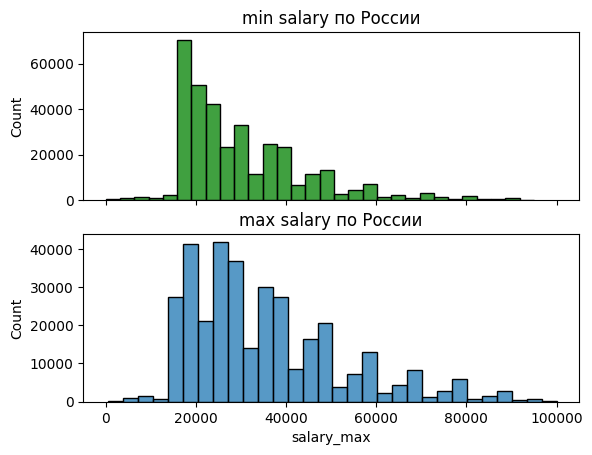

In [10]:
def plot_salary_hist(data: pd.DataFrame, ax0, ax1, title=["", ""], q=0.99, bins=20):
    """plot minimum and maximum salary histogram

    Args:
        data (pd.DataFrame): our dataframe with columns 'salary_min', 'salary_max
        ax0: axis on which minimum salary plotted
        ax1: axis on which maximum salary plotted
        title (list, optional): List of title to set on axes. Defaults to ['', '']
        q (float, optional): salary more that q'th percentile are dropped
        bins (int, optional): number of bins to create histogram.
    """
    salary_region = data[["salary_min", "salary_max"]].dropna()
    salary_region = salary_region[
        salary_region["salary_min"] < salary_region["salary_min"].quantile(q)
    ]
    salary_region = salary_region[
        salary_region["salary_max"] < salary_region["salary_max"].quantile(q)
    ]
    ax0.set_title(title[0])
    ax1.set_title(title[1])
    sns.histplot(
        salary_region,
        x="salary_min",
        ax=ax0,
        bins=bins,
        color="g",
        legend=title[0] + ": salary_min",
    )
    sns.histplot(
        salary_region,
        x="salary_max",
        ax=ax1,
        bins=bins,
        legend=title[1] + ": salary_max",
    )


def plot_single_salary_hist(data: pd.DataFrame, title=["", ""], q=1, bins=20):
    """Just plots single salary histogram

    Args:
        data (pd.DataFrame): our dataframe with columns 'salary_min', 'salary_max
        title (list, optional): titles of axes
        q (float, optional): salary more that q'th percentile are dropped
        bins (int, optional): number of bins to create histogram.
    """
    fig, axs = plt.subplots(nrows=2, sharex=True)
    plot_salary_hist(data, axs[0], axs[1], title=title, q=q, bins=bins)
    plt.show()


plot_single_salary_hist(
    data, q=0.98, bins=30, title=["min salary по России", "max salary по России"]
)

Теперь напишем функцию, чтобы рисовать неограниченное число графиков рядом, чтобы было их удобно сравнивать. Всё что нам нужно это передавать DataFrame которые мы хотим сравнить. 

Например покажем сравнение зарплат регионов из службы занятости: 
- Иркутская область
- Респ. Татарстан
- Респ. Бурятия
- г. Москва

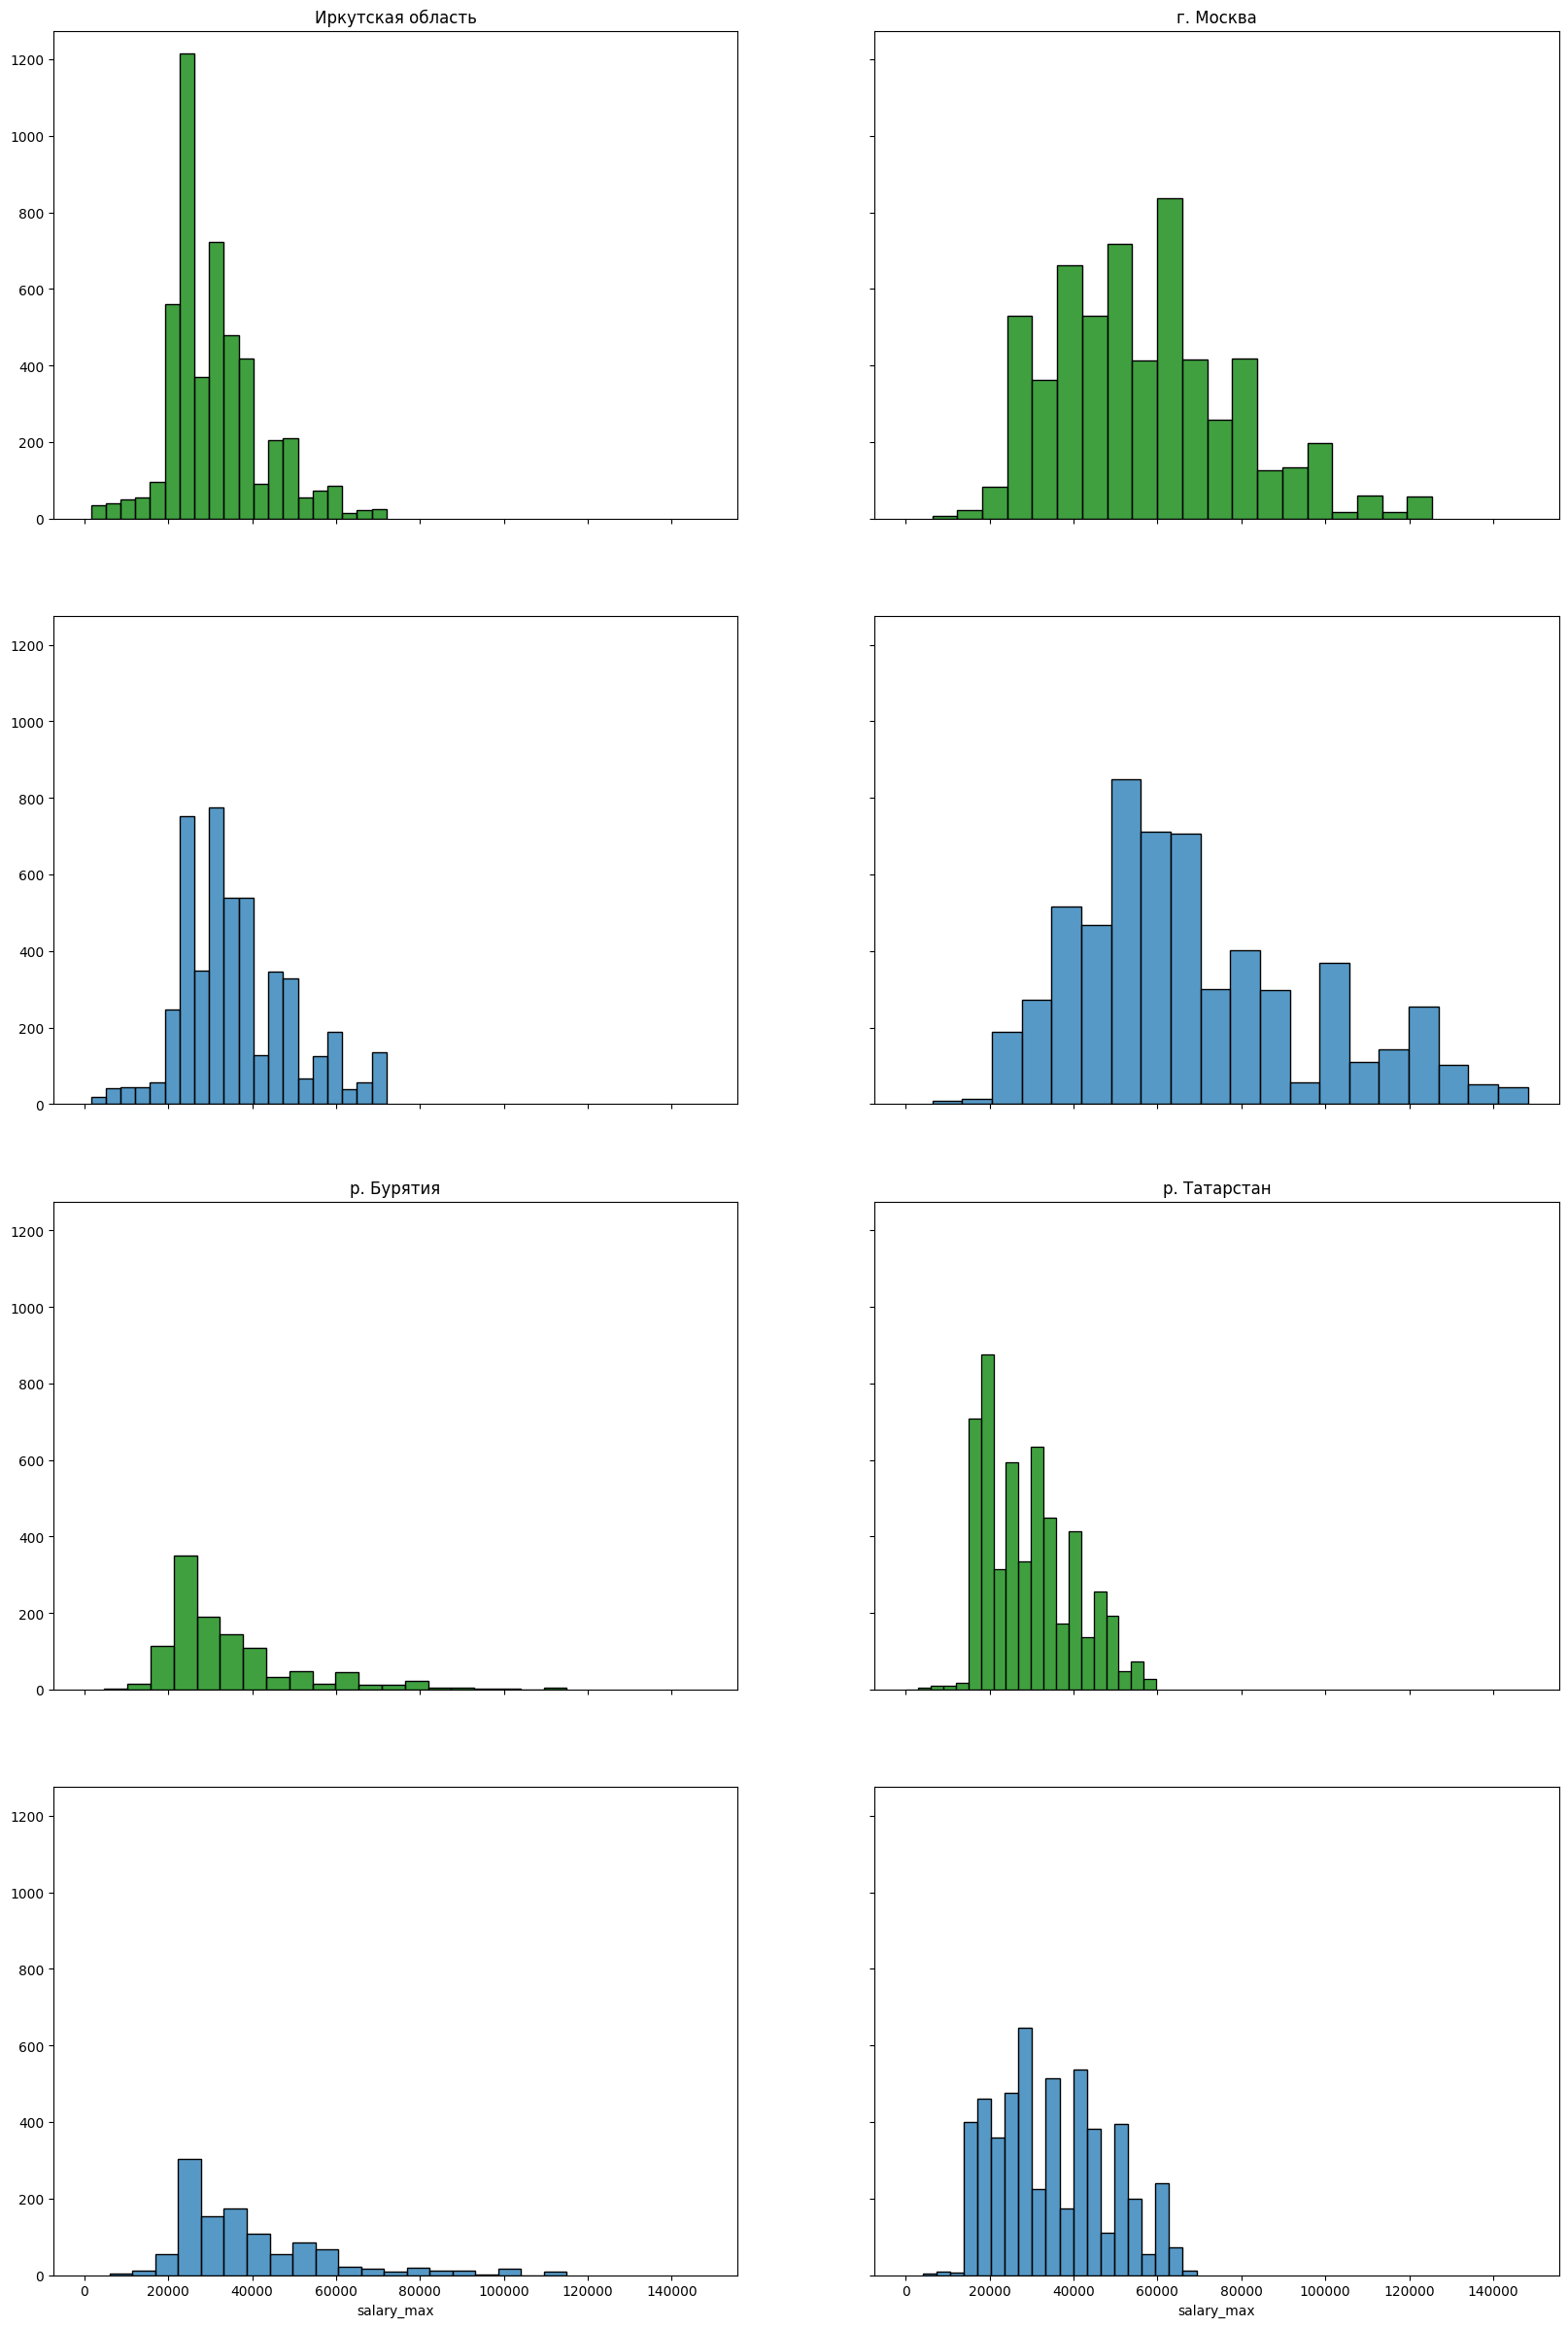

In [11]:
from math import ceil


def plot_comparasion(*data, ncols=2, data_titles=None, q=1, bins=20, fig_size=(10, 15)):
    """plot comparasion on a salary histogram with not fixed number of data

    Args:
        *data (List(pd.DataFrame)): list of dataframes to plot.
        ncols (int, optional): Number of columns. Defaults to 2.
        data_titles (list, optional): string title for every DataFrame. Defaults to None.
        q (int, optional): salary more that q'th percentile are dropped. Defaults to 1.
        bins (int, optional): number of bins to create histogram. Defaults to 20.
        fig_size (list, optional): fig size of individual data plot. Defaults to (15, 10)
    """
    if len(data_titles) != len(data):
        raise ValueError(
            "length of data_titles should be equal to number of passing dataframes"
        )
    fig, axs = plt.subplots(
        ncols=ncols,
        nrows=ceil(len(data) / ncols) * 2,
        sharex=True,
        sharey=True,
        squeeze=True,
    )
    fig.set_figwidth(fig_size[0] * ncols)
    fig.set_figheight(fig_size[1] * len(data) // ncols)
    for i in range(len(data)):
        column = i % ncols
        row = (i // ncols) * 2
        plot_salary_hist(
            data[i], axs[row][column], axs[row + 1][column], q=q, bins=bins
        )
        if data_titles:
            axs[row][column].set_title(data_titles[i])
        axs[row][column].set_ylabel("")
        axs[row + 1][column].set_ylabel("")
    plt.show()


irk = data[
    (data["regionName"] == "Иркутская область")
    & (data["source_type"] != "Служба занятости")
]

moscow = data[
    (data["regionName"] == "г. Москва") & (data["source_type"] != "Служба занятости")
]

buryatia = data[
    (data["regionName"] == "Республика Бурятия")
    & (data["source_type"] != "Служба занятости")
]
tatarstan = data[
    (data["regionName"] == "Республика Татарстан")
    & (data["source_type"] != "Служба занятости")
]

plot_comparasion(
    irk,
    moscow,
    buryatia,
    tatarstan,
    data_titles=["Иркутская область", "г. Москва", "р. Бурятия", "р. Татарстан"],
    q=0.95,
)

Давайте найдём среди этих данных учителей используя RegExp

In [12]:
import re


def get_apply_func(pattern: str):
    """generates function to apply pattern for every vacancy name

    Args:
        pattern (str): regexp pattern
    """

    def select_teachers(row):
        vacancy_name = row.vacancy_name
        if not pd.isna(vacancy_name):
            out = re.match(pattern, vacancy_name)
            if out:
                return True
        return False

    return select_teachers


teachers = data[data.apply(get_apply_func("учит|преподават"), axis=1)]

Чтобы лучше понимать разницу между регионами, используем geopandas для отображение карты России и её регионов. Найденная карта устарела и содержит регионы, которых сейчас не существует, поэтому давайте исправим это

<AxesSubplot: >

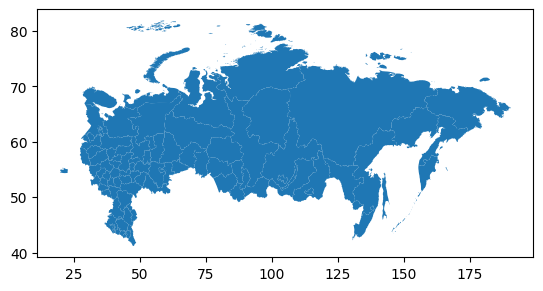

In [13]:
russia_map = gpd.read_file("regions2/regions2.shp")
russia_map.NAME.replace(
    {
        "Ненецкий а.о.": "Ямало-Ненецкий а.о.",
        "Таймырский (Долгано-Ненецкий) а.о.": "Красноярский край",
        "Эвенкийский а.о.": "Красноярский край",
        "Коми-Пермяцкий а.о.": "Пермская обл.",
        "Агинский Бурятский а.о.": "Читинская обл.",
        "Корякский а.о.": "Камчатская обл.",
        "Усть-Ордынский Бурятский а.о.": "Иркутская обл.",
    },
    regex=False,
    inplace=True,
)
russia_map.to_crs(epsg=4326).plot()

Формат названия регионов немного отличается у наших данных и карты. Используем библиотеку `fuzzywuzzy`, чтобы быстро их сопоставить.   

In [14]:
from fuzzywuzzy import process

def get_conversion(map, data):
    map_uniq = map.NAME.unique()
    data_uniq = data.regionName.unique()
    conversion = {}
    for region in data_uniq:
        best_match, score = process.extractOne(region, map_uniq)
        if score > 50:
            conversion[region] = best_match
    return conversion
conversion = get_conversion(russia_map, data)
conversion

{'Краснодарский край': 'Краснодарский край',
 'Пермский край': 'Приморский край',
 'Новосибирская область': 'Новосибирская обл.',
 'Сахалинская область': 'Сахалинская обл.',
 'Ленинградская область': 'Ленинградская обл.',
 'Ставропольский край': 'Ставропольский край',
 'Республика Татарстан': 'Респ. Татарстан (Татарстан)',
 'Камчатский край': 'Алтайский край',
 'г. Москва': 'Московская обл.',
 'Приморский край': 'Приморский край',
 'Алтайский край': 'Алтайский край',
 'Калининградская область': 'Калининградская обл.',
 'Республика Саха (Якутия)': 'Респ. Саха (Якутия)',
 'Ульяновская область': 'Ульяновская обл.',
 'Удмуртская Республика': 'Удмуртская Респ.',
 'Тверская область': 'Тверская обл.',
 'Московская область': 'Московская обл.',
 'Ярославская область': 'Ярославская обл.',
 'Челябинская область': 'Челябинская обл.',
 'Свердловская область': 'Свердловская обл.',
 'Калужская область': 'Калужская обл.',
 'Архангельская область': 'Архангельская обл.',
 'Нижегородская область': 'Нижег

Вручную пройдясь исправим ошибки и нормализуем данные

In [15]:
conversion['Забайкальский край'] = "Читинская обл."
conversion['Пермский край'] = "Пермская обл."
conversion['Камчатский край'] = "Камчатская обл."
conversion['Еврейская автономная обл.'] = "Еврейская авт. обл."

In [16]:
def norm_data(data: pd.DataFrame, conversion):
    test_data = data.copy()
    test_data.regionName.replace(
        {"область": "обл.", "Республика": "Респ."}, inplace=True, regex=True
    )
    test_data.regionName.replace(conversion, regex=False, inplace=True)
    return test_data
data = norm_data(data, conversion)

Отобразим средную минимальную зарплату учителей по регионам

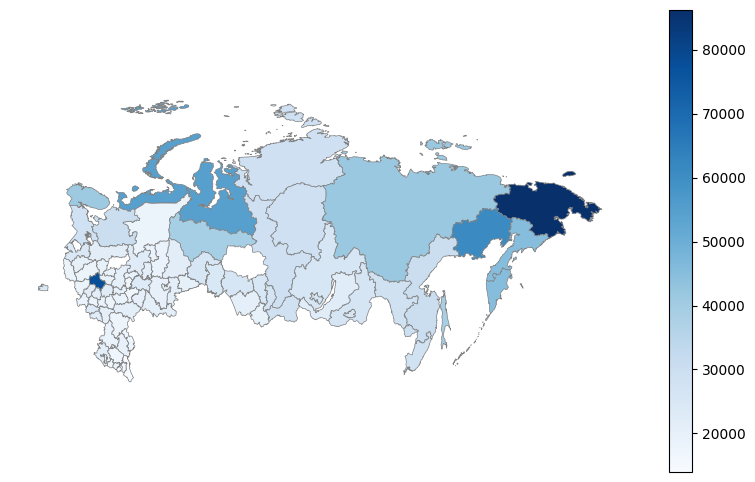

In [17]:


def draw_map_plot(map: pd.DataFrame, data: pd.DataFrame) -> None:
    """Рисует карту зарпалт россии по данных. NaN отображаются как 0

    Args:
        map (pd.DataFrame): карта
        data (pd.DataFrame): данные
    """
    data.regionName.replace(conversion, regex=False, inplace=True)
    map = map.merge(data, left_on="NAME", right_on="regionName", how="left")
    map.salary_min.fillna(0)
    fig, ax = plt.subplots(1, figsize=(10, 6))
    map.plot(
        column="salary_min",
        cmap="Blues",
        linewidth=0.5,
        ax=ax,
        edgecolor="0.5",
        legend=True
    )
    ax.axis("off")

mean_salaries = (
    teachers[["regionName", "salary_min"]].groupby("regionName", as_index=False).mean()
)

draw_map_plot(russia_map, mean_salaries)

## МЛ
Давайте попробуем предсказывать зарплаты учителей используя 

In [18]:
from sklearn.model_selection import train_test_split

x = teachers[['busy_type', 'education', 'regionName', 'company_business_size']]
x = pd.get_dummies(x)
y = teachers['salary_min']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [19]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression()

In [20]:
from sklearn.metrics import r2_score
preds = regr.predict(x_test)
r2_score(y_test, preds)

0.658155152370937

r2 score, не очень высокий. Давайте посмотрим какие колонки влияли больше всего

In [21]:
import numpy as np
absolute_coefficients = np.abs(regr.coef_)

# Sort the coefficients and corresponding column names by their absolute values
sorted_indices = np.argsort(absolute_coefficients)[::-1]
sorted_coefficients = regr.coef_[sorted_indices]
sorted_column_names = x.columns[sorted_indices]
n = 20
for column_name, coefficient in zip(sorted_column_names[:n], sorted_coefficients[:n]):
    print(f"Column: {column_name}, Weight: {coefficient}")

Column: education_Незаконченное высшее, Weight: 5.38606391740362e+16
Column: education_Высшее, Weight: 5.386063917403571e+16
Column: education_Не указано, Weight: 5.3860639174035304e+16
Column: education_Среднее, Weight: 5.3860639174034984e+16
Column: education_Среднее профессиональное, Weight: 5.3860639174034296e+16
Column: company_business_size_BIG, Weight: -3.4720935582168464e+16
Column: company_business_size_SMALL, Weight: -3.472093558216567e+16
Column: company_business_size_MIDDLE, Weight: -3.4720935582165652e+16
Column: company_business_size_MICRO, Weight: -3.472093558216529e+16
Column: company_business_size_LARGE, Weight: -3.47209355821523e+16
Column: regionName_Республика Дагестан, Weight: -1.0536346104056316e+16
Column: regionName_Чеченская Республика, Weight: -1.053634610405453e+16
Column: regionName_Карачаево-Черкесская Республика, Weight: -1.0536346104054506e+16
Column: regionName_Республика Северная Осетия-Алания, Weight: -1.0536346104054444e+16
Column: regionName_Республи